In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,ConfusionMatrixDisplay
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.pipeline import Pipeline as ImbPipeline

# Áp dụng mô hình SVM vào bộ dữ liệu

In [2]:
import os
BASE_DIR = os.path.dirname(
    os.path.dirname(
        os.path.dirname(
            os.path.abspath('notebook/preprocessing.ipynb'))))

# Sử dụng trên bộ dữ liệu 9 class và 4 class
# Do đầu ra của bộ dữ liệu có một số class quá ít nên ta tiến hành loại bỏ các hàng dữ liệu chứa các class thiểu số đó
df_4_class = pd.read_csv(os.path.join(BASE_DIR, 'data/processed_data_4_classes.csv'))
df_9_class = pd.read_csv(os.path.join(BASE_DIR, 'data/processed_data_9_classes.csv'))

df_9_class_pca = pd.read_csv(os.path.join(BASE_DIR, 'data/X_9_classes_PCA_6dims.csv'))
df_4_class_pca = pd.read_csv(os.path.join(BASE_DIR, 'data/X_4_classes_PCA_6dims.csv'))

df_9_class_lda = pd.read_csv(os.path.join(BASE_DIR, 'data/X_9_classes_LDA_2dims.csv'))
df_4_class_lda = pd.read_csv(os.path.join(BASE_DIR, 'data/X_4_classes_LDA_2dims.csv'))

In [3]:
def test_svm(df, test_size):
  # split dữ liệu
  target = 'Classification'
  x = df.drop(target, axis = 1)
  y = df[target]
  x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42, stratify=y)

  # gọi svm trong sklearn sử dụng kernel = rbf
  model = Pipeline([
      ("scaler", StandardScaler()),
      ("svc", SVC(kernel="rbf", C=1, gamma="scale", class_weight="balanced", random_state=42))
  ])
  model.fit(x_train, y_train)

  # Dự đoán mô hình

  y_pred = model.predict(x_test)
  classes = model.named_steps["svc"].classes_
  print('Kết quả của mô hình khi chưa được tối ưu các tham số')
  print(classification_report(y_test,y_pred))
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot(cmap='Blues', xticks_rotation=45)
  plt.title("Confusion Matrix: Thực tế vs Dự đoán")
  plt.show()

  # Gridsearch để tìm ra bộ tham số tối ưu
  param_grid = {
    "svc__C": [0.1, 1, 10, 100, 1000],
    "svc__gamma": ["scale", 1e-3, 1e-2, 1e-1, 1],
    "svc__kernel" : ['linear', 'poly', 'rbf', 'sigmoid']
}

  cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
  gs = GridSearchCV(
      estimator=model,
      param_grid=param_grid,
      scoring="f1_macro",
      cv=cv,
      n_jobs=-1,
      verbose=2,
      refit=True
  )
  gs.fit(x_train, y_train)
  print('----------------------------------')
  print('Kết quả khi tối ưu các tham số của mô hình')
  print("Best params:", gs.best_params_)
  print("Best CV f1_macro:", gs.best_score_)

  best_model = gs.best_estimator_
  y_pred = best_model.predict(x_test)

  print(classification_report(y_test, y_pred, digits=4))
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot(cmap='Blues', xticks_rotation=45)
  plt.title("Confusion Matrix: Thực tế vs Dự đoán")
  plt.show()


## Trên bộ dữ liệu gốc gồm 9 class

### Kịch bản 1 (Train / Test = 0.8/0.2)

Kết quả của mô hình khi chưa được tối ưu các tham số
              precision    recall  f1-score   support

        C2S1       0.74      1.00      0.85        50
        C3S1       0.98      0.79      0.88       140
        C3S2       0.00      0.00      0.00         2
        C3S3       0.00      0.00      0.00         1
        C4S1       0.62      0.83      0.71        18
        C4S2       0.27      0.43      0.33         7
        C4S3       0.00      0.00      0.00         1
        C4S4       0.00      0.00      0.00         1
          OG       0.00      0.00      0.00         1

    accuracy                           0.81       221
   macro avg       0.29      0.34      0.31       221
weighted avg       0.85      0.81      0.82       221



f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

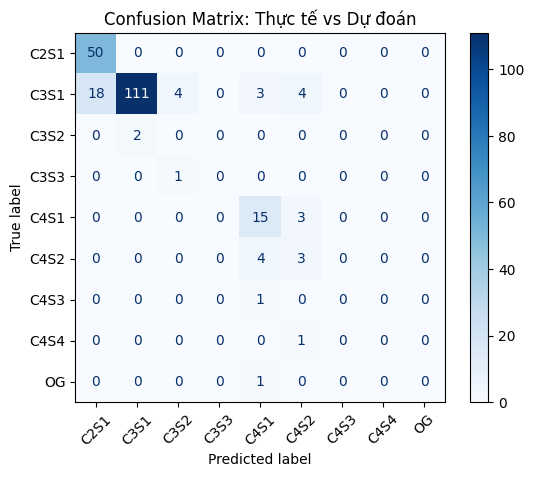

Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------------------------------
Kết quả khi tối ưu các tham số của mô hình
Best params: {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best CV f1_macro: 0.7065526738838254
              precision    recall  f1-score   support

        C2S1     0.9615    1.0000    0.9804        50
        C3S1     0.9853    0.9571    0.9710       140
        C3S2     0.0000    0.0000    0.0000         2
        C3S3     0.5000    1.0000    0.6667         1
        C4S1     0.9412    0.8889    0.9143        18
        C4S2     0.6667    0.8571    0.7500         7
        C4S3     0.0000    0.0000    0.0000         1
        C4S4     0.0000    0.0000    0.0000         1
          OG     0.0000    0.0000    0.0000         1

    accuracy                         0.9367       221
   macro avg     0.4505    0.5226    0.4758       221
weighted avg     0.9417    0.9367    0.9382       221



f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

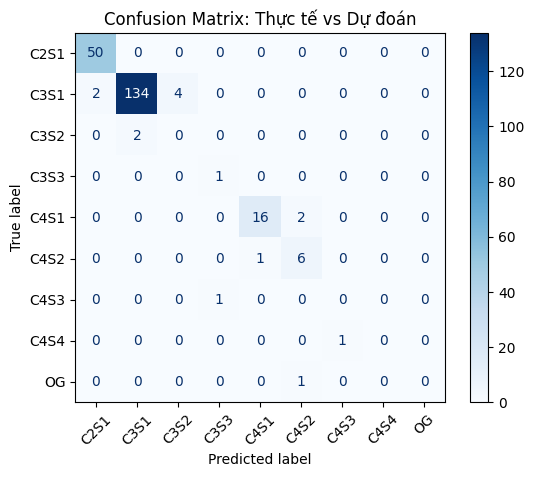

In [4]:
test_svm(df_9_class, test_size=0.2)

### kịch bản 2 (Train/Test = 0.7/0.3)

Kết quả của mô hình khi chưa được tối ưu các tham số
              precision    recall  f1-score   support

        C2S1       0.71      1.00      0.83        75
        C3S1       0.98      0.80      0.88       209
        C3S2       0.20      0.25      0.22         4
        C3S3       1.00      0.50      0.67         2
        C4S1       0.71      0.85      0.77        26
        C4S2       0.40      0.55      0.46        11
        C4S3       0.00      0.00      0.00         1
        C4S4       1.00      0.50      0.67         2
          OG       0.00      0.00      0.00         1

    accuracy                           0.83       331
   macro avg       0.55      0.49      0.50       331
weighted avg       0.86      0.83      0.83       331



f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

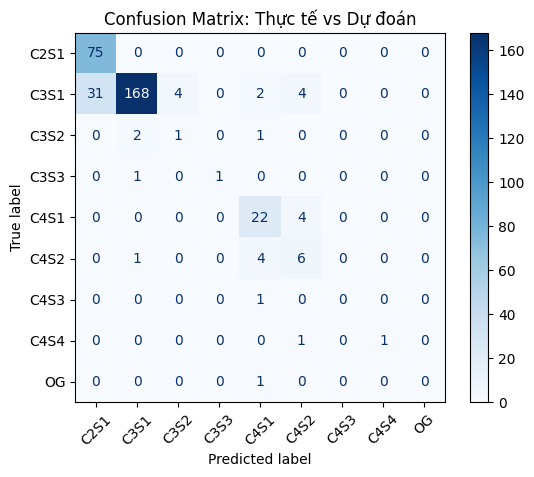

Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------------------------------
Kết quả khi tối ưu các tham số của mô hình
Best params: {'svc__C': 1000, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best CV f1_macro: 0.6388561468530792
              precision    recall  f1-score   support

        C2S1     0.9615    1.0000    0.9804        75
        C3S1     0.9803    0.9522    0.9660       209
        C3S2     0.1667    0.2500    0.2000         4
        C3S3     0.5000    0.5000    0.5000         2
        C4S1     0.8462    0.8462    0.8462        26
        C4S2     0.5000    0.6364    0.5600        11
        C4S3     0.0000    0.0000    0.0000         1
        C4S4     1.0000    0.5000    0.6667         2
          OG     0.0000    0.0000    0.0000         1

    accuracy                         0.9245       331
   macro avg     0.5505    0.5205    0.5244       331
weighted avg     0.9310    0.9245    0.9266       331



f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

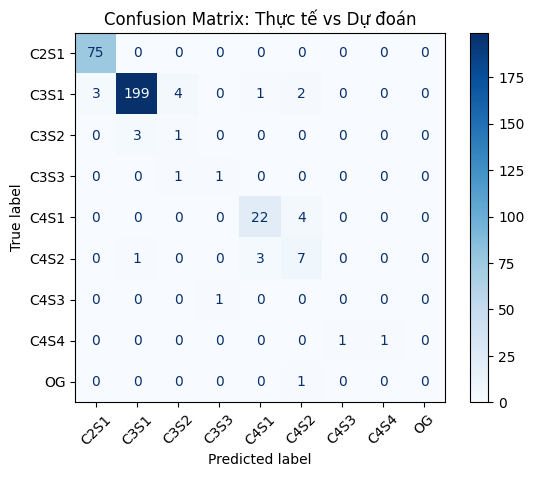

In [5]:
test_svm(df_9_class, test_size=0.3)

### kịch bản 3 (Train/Test = 0.6/0.4)

Kết quả của mô hình khi chưa được tối ưu các tham số
              precision    recall  f1-score   support

        C2S1       0.71      1.00      0.83        99
        C3S1       0.99      0.79      0.88       279
        C3S2       0.29      0.40      0.33         5
        C3S3       1.00      1.00      1.00         2
        C4S1       0.58      0.86      0.69        35
        C4S2       0.40      0.43      0.41        14
        C4S3       0.00      0.00      0.00         2
        C4S4       0.00      0.00      0.00         3
          OG       1.00      0.50      0.67         2

    accuracy                           0.82       441
   macro avg       0.55      0.55      0.53       441
weighted avg       0.85      0.82      0.82       441



f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

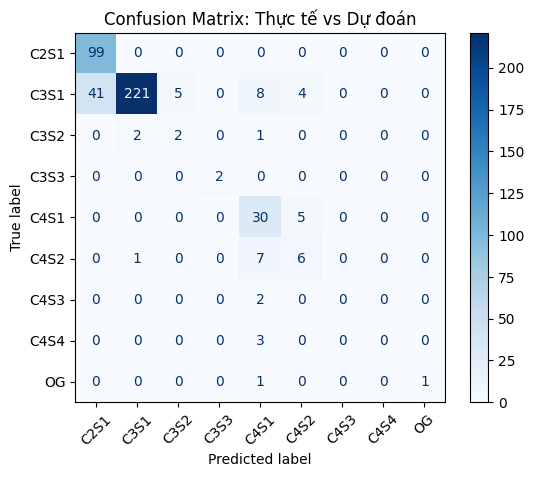

f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\model_selection\_split.py:813: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------------------------------
Kết quả khi tối ưu các tham số của mô hình
Best params: {'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}
Best CV f1_macro: 0.5669982364652397
              precision    recall  f1-score   support

        C2S1     0.9643    0.8182    0.8852        99
        C3S1     0.9241    0.9606    0.9420       279
        C3S2     0.2222    0.4000    0.2857         5
        C3S3     0.3333    0.5000    0.4000         2
        C4S1     0.7632    0.8286    0.7945        35
        C4S2     0.5385    0.5000    0.5185        14
        C4S3     0.0000    0.0000    0.0000         2
        C4S4     1.0000    0.3333    0.5000         3
          OG     0.5000    0.5000    0.5000         2

    accuracy                         0.8844       441
   macro avg     0.5828    0.5379    0.5362       441
weighted avg     0.8919    0.8844    0.8849       441



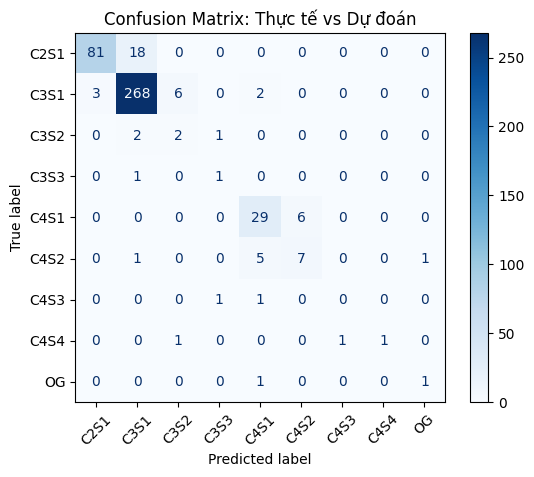

In [6]:
test_svm(df_9_class, test_size=0.4)

Nhận xét :
- Mô hình dự đoán tốt trên các class đa số, kém trên các class thiểu số
- avg marco f1 score lần lượt là : 0.47, 0.52, 0.53

## Trên bộ dữ liệu gốc gồm 4 class

### Kịch bản 1 (Train/Test = 0.8/0.2)

Kết quả của mô hình khi chưa được tối ưu các tham số
              precision    recall  f1-score   support

        C2S1       0.78      1.00      0.88        50
        C3S1       1.00      0.87      0.93       140
        C4S1       0.75      0.88      0.81        17
        C4S2       0.62      0.71      0.67         7

    accuracy                           0.90       214
   macro avg       0.79      0.87      0.82       214
weighted avg       0.92      0.90      0.90       214



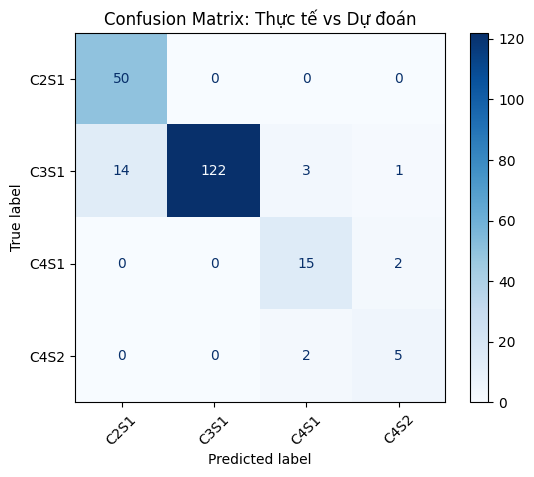

Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------------------------------
Kết quả khi tối ưu các tham số của mô hình
Best params: {'svc__C': 1000, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best CV f1_macro: 0.7966787517021996
              precision    recall  f1-score   support

        C2S1     0.9804    1.0000    0.9901        50
        C3S1     1.0000    0.9714    0.9855       140
        C4S1     0.9286    0.7647    0.8387        17
        C4S2     0.4615    0.8571    0.6000         7

    accuracy                         0.9579       214
   macro avg     0.8426    0.8983    0.8536       214
weighted avg     0.9721    0.9579    0.9623       214



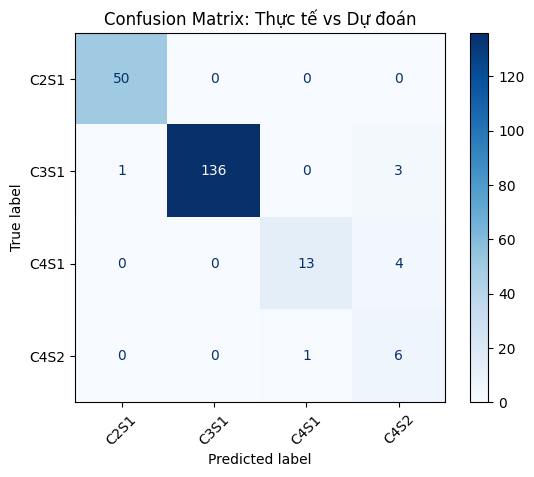

In [7]:
test_svm(df_4_class, test_size=0.2)

### kịch bản 2 (Train/Test = 0.7/0.3)

Kết quả của mô hình khi chưa được tối ưu các tham số
              precision    recall  f1-score   support

        C2S1       0.75      1.00      0.86        75
        C3S1       1.00      0.86      0.92       209
        C4S1       0.71      0.85      0.77        26
        C4S2       0.45      0.45      0.45        11

    accuracy                           0.88       321
   macro avg       0.73      0.79      0.75       321
weighted avg       0.90      0.88      0.88       321



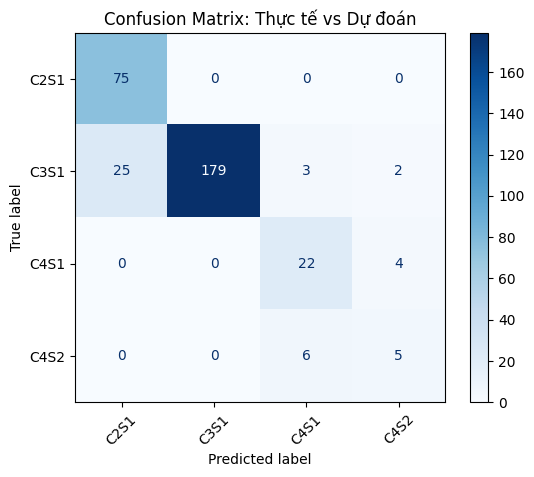

Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------------------------------
Kết quả khi tối ưu các tham số của mô hình
Best params: {'svc__C': 10, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best CV f1_macro: 0.7533238316048286
              precision    recall  f1-score   support

        C2S1     0.9036    1.0000    0.9494        75
        C3S1     0.9950    0.9474    0.9706       209
        C4S1     0.8636    0.7308    0.7917        26
        C4S2     0.4706    0.7273    0.5714        11

    accuracy                         0.9346       321
   macro avg     0.8082    0.8514    0.8208       321
weighted avg     0.9450    0.9346    0.9375       321



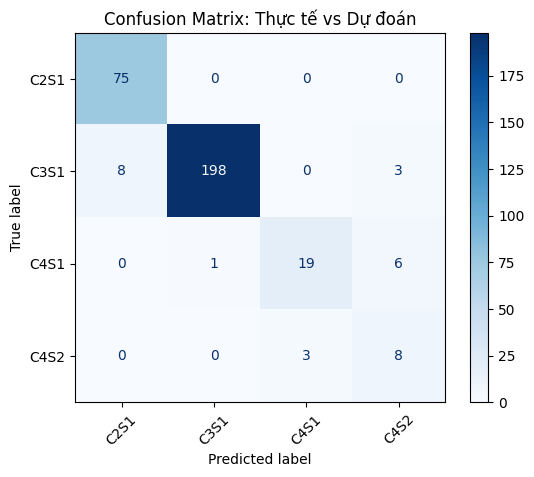

In [8]:
test_svm(df_4_class, test_size=0.3)

### Kịch bản 3 (Train/Test = 0.6/0.4)

Kết quả của mô hình khi chưa được tối ưu các tham số
              precision    recall  f1-score   support

        C2S1       0.73      1.00      0.85        99
        C3S1       1.00      0.84      0.91       279
        C4S1       0.68      0.86      0.76        35
        C4S2       0.38      0.36      0.37        14

    accuracy                           0.86       427
   macro avg       0.70      0.76      0.72       427
weighted avg       0.89      0.86      0.87       427



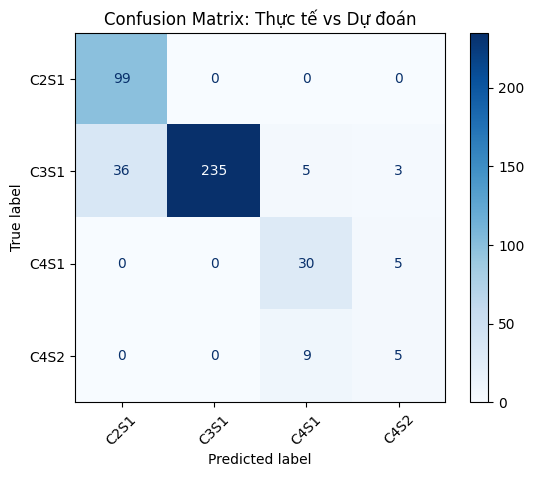

Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------------------------------
Kết quả khi tối ưu các tham số của mô hình
Best params: {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best CV f1_macro: 0.783965730723201
              precision    recall  f1-score   support

        C2S1     0.9429    1.0000    0.9706        99
        C3S1     0.9926    0.9570    0.9745       279
        C4S1     0.8966    0.7429    0.8125        35
        C4S2     0.4583    0.7857    0.5789        14

    accuracy                         0.9438       427
   macro avg     0.8226    0.8714    0.8341       427
weighted avg     0.9557    0.9438    0.9473       427



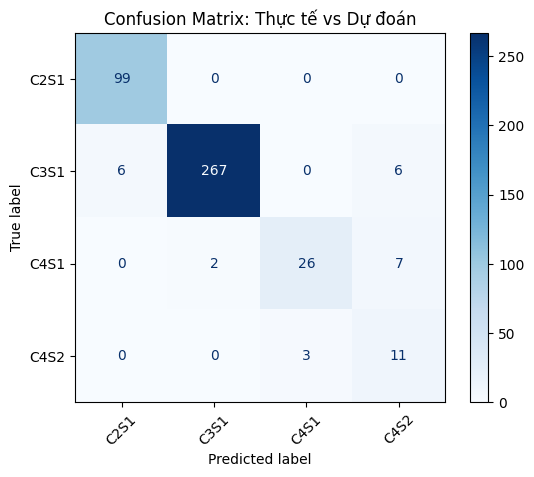

In [9]:
test_svm(df_4_class, test_size=0.4)

Nhận xét :
- Độ chính xác của mô hình được cải thiện đáng kể
- sử dụng kenerl = linear thì giúp mô hình tối ưu nhất
- avg marco f1 score lần lượt là : 0.85, 0.82, 0.84

## Test trong trường hợp giảm chiều dữ liệu bằng pca, đầu ra là 9 class

### kịch bản 1(Train/Test = 0.8/0.2)

Kết quả của mô hình khi chưa được tối ưu các tham số
              precision    recall  f1-score   support

        C2S1       0.68      0.98      0.80        50
        C3S1       0.97      0.71      0.82       140
        C3S2       0.17      0.50      0.25         2
        C3S3       0.00      0.00      0.00         1
        C4S1       0.52      0.83      0.64        18
        C4S2       0.25      0.43      0.32         7
        C4S3       0.00      0.00      0.00         1
        C4S4       0.00      0.00      0.00         1
          OG       0.00      0.00      0.00         1

    accuracy                           0.76       221
   macro avg       0.29      0.38      0.31       221
weighted avg       0.82      0.76      0.76       221



f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

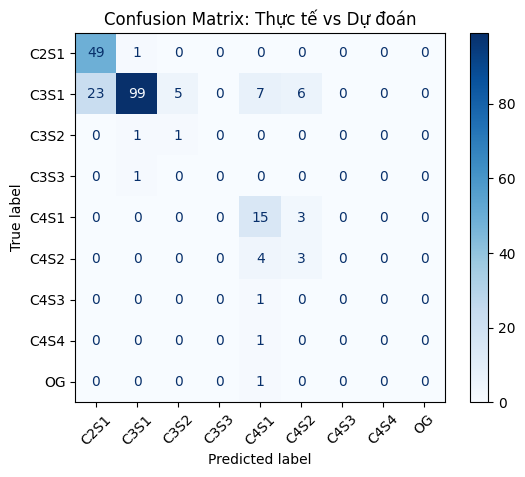

Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------------------------------
Kết quả khi tối ưu các tham số của mô hình
Best params: {'svc__C': 1000, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best CV f1_macro: 0.5936900497031815
              precision    recall  f1-score   support

        C2S1     0.8772    1.0000    0.9346        50
        C3S1     0.9766    0.8929    0.9328       140
        C3S2     0.0000    0.0000    0.0000         2
        C3S3     0.0000    0.0000    0.0000         1
        C4S1     0.7500    1.0000    0.8571        18
        C4S2     0.4286    0.4286    0.4286         7
        C4S3     0.0000    0.0000    0.0000         1
        C4S4     0.0000    0.0000    0.0000         1
          OG     0.0000    0.0000    0.0000         1

    accuracy                         0.8869       221
   macro avg     0.3369    0.3690    0.3503       221
weighted avg     0.8918    0.8869    0.8858       221



f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

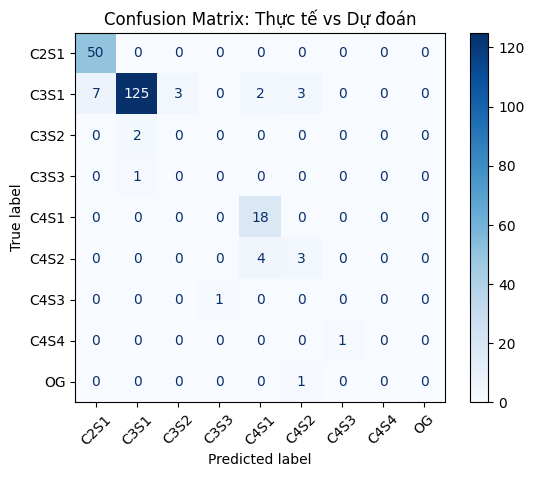

In [10]:
test_svm(df_9_class_pca, 0.2)

### kịch bản 2 (Train/Test = 0.7/0.3)

Kết quả của mô hình khi chưa được tối ưu các tham số
              precision    recall  f1-score   support

        C2S1       0.63      0.99      0.77        75
        C3S1       0.97      0.69      0.80       209
        C3S2       0.11      0.25      0.15         4
        C3S3       1.00      0.50      0.67         2
        C4S1       0.55      0.81      0.66        26
        C4S2       0.33      0.45      0.38        11
        C4S3       0.00      0.00      0.00         1
        C4S4       1.00      0.50      0.67         2
          OG       0.00      0.00      0.00         1

    accuracy                           0.75       331
   macro avg       0.51      0.47      0.46       331
weighted avg       0.82      0.75      0.76       331



f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

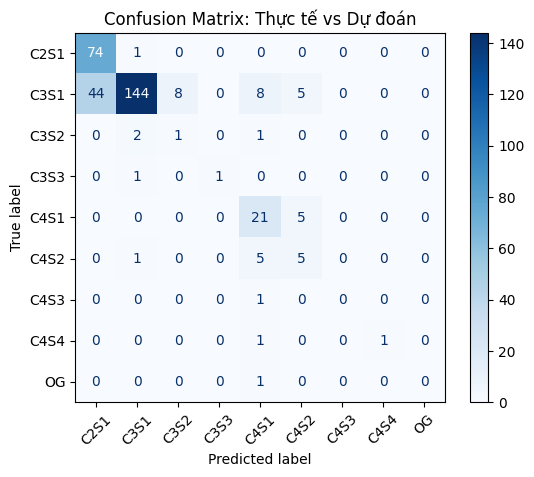

Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------------------------------
Kết quả khi tối ưu các tham số của mô hình
Best params: {'svc__C': 100, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best CV f1_macro: 0.5468957901782635
              precision    recall  f1-score   support

        C2S1     0.7653    1.0000    0.8671        75
        C3S1     0.9663    0.8230    0.8889       209
        C3S2     0.2500    0.5000    0.3333         4
        C3S3     1.0000    0.5000    0.6667         2
        C4S1     0.6333    0.7308    0.6786        26
        C4S2     0.3077    0.3636    0.3333        11
        C4S3     0.5000    1.0000    0.6667         1
        C4S4     1.0000    0.5000    0.6667         2
          OG     0.0000    0.0000    0.0000         1

    accuracy                         0.8308       331
   macro avg     0.6025    0.6019    0.5668       331
weighted avg     0.8601    0.8308    0.8362       331



f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

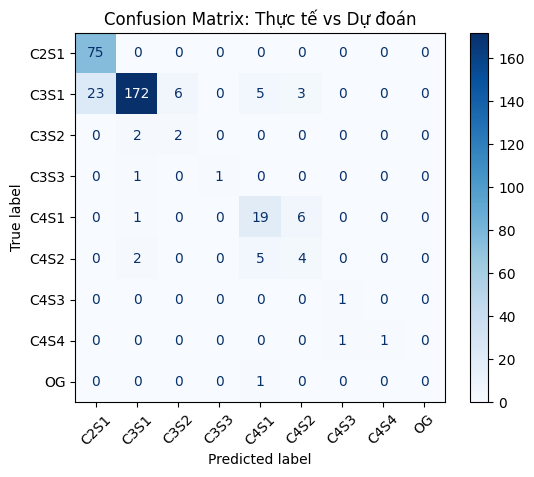

In [11]:
test_svm(df_9_class_pca, 0.3)

### Kịch bản 3 (Train/Test = 0.6/0.4)

Kết quả của mô hình khi chưa được tối ưu các tham số
              precision    recall  f1-score   support

        C2S1       0.66      0.99      0.79        99
        C3S1       0.98      0.71      0.82       279
        C3S2       0.18      0.40      0.25         5
        C3S3       0.33      0.50      0.40         2
        C4S1       0.52      0.86      0.65        35
        C4S2       0.27      0.29      0.28        14
        C4S3       0.00      0.00      0.00         2
        C4S4       0.00      0.00      0.00         3
          OG       0.00      0.00      0.00         2

    accuracy                           0.76       441
   macro avg       0.33      0.42      0.35       441
weighted avg       0.82      0.76      0.76       441



f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

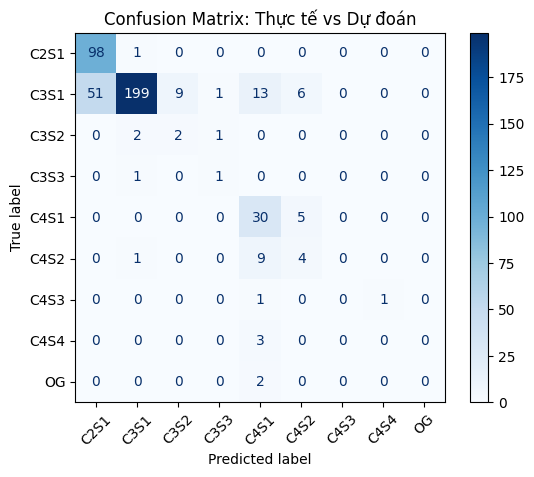

Fitting 3 folds for each of 100 candidates, totalling 300 fits


f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\model_selection\_split.py:813: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


----------------------------------
Kết quả khi tối ưu các tham số của mô hình
Best params: {'svc__C': 1000, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}
Best CV f1_macro: 0.5056280331586707
              precision    recall  f1-score   support

        C2S1     0.7481    0.9899    0.8522        99
        C3S1     0.9547    0.8315    0.8889       279
        C3S2     0.0000    0.0000    0.0000         5
        C3S3     0.3333    0.5000    0.4000         2
        C4S1     0.6341    0.7429    0.6842        35
        C4S2     0.3333    0.3571    0.3448        14
        C4S3     0.0000    0.0000    0.0000         2
        C4S4     0.5000    0.3333    0.4000         3
          OG     0.0000    0.0000    0.0000         2

    accuracy                         0.8231       441
   macro avg     0.3893    0.4172    0.3967       441
weighted avg     0.8378    0.8231    0.8234       441



f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

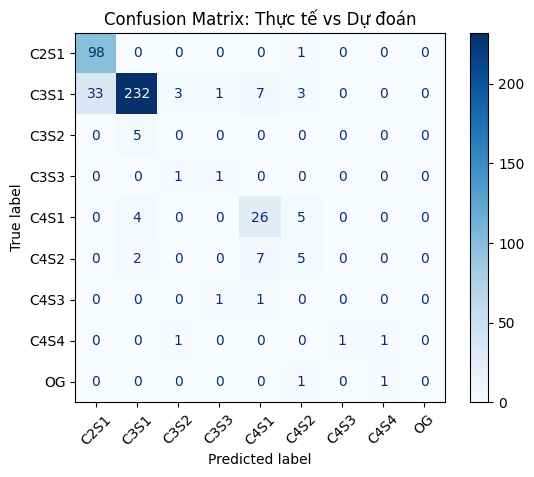

In [12]:
test_svm(df_9_class_pca, 0.4)

Nhận xét:
- Mô hình dự đoán vẫn bị sai ở các class thiểu số

## Test khi giảm chiều dữ liệu bằng pca, đầu ra là 4 class

### Kịch bản 1 (Train/Test = 0.8/0.2)

Kết quả của mô hình khi chưa được tối ưu các tham số
              precision    recall  f1-score   support

        C2S1       0.72      0.98      0.83        50
        C3S1       0.99      0.80      0.89       140
        C4S1       0.59      0.94      0.73        17
        C4S2       0.50      0.43      0.46         7

    accuracy                           0.84       214
   macro avg       0.70      0.79      0.73       214
weighted avg       0.88      0.84      0.85       214



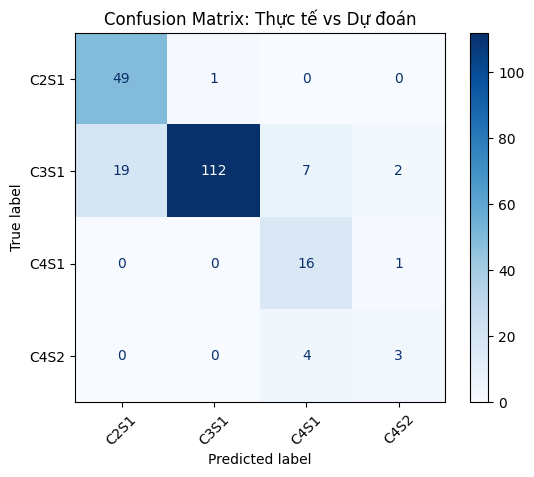

Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------------------------------
Kết quả khi tối ưu các tham số của mô hình
Best params: {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best CV f1_macro: 0.7596607957281619
              precision    recall  f1-score   support

        C2S1     0.8772    1.0000    0.9346        50
        C3S1     1.0000    0.9286    0.9630       140
        C4S1     0.8000    0.9412    0.8649        17
        C4S2     0.4286    0.4286    0.4286         7

    accuracy                         0.9299       214
   macro avg     0.7764    0.8246    0.7977       214
weighted avg     0.9367    0.9299    0.9311       214



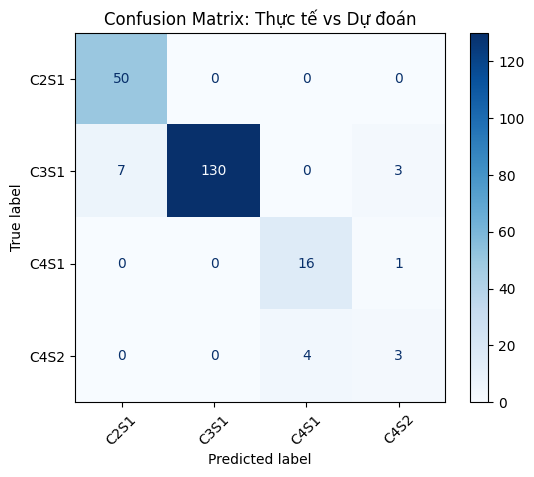

In [13]:
test_svm(df_4_class_pca, 0.2)

### Kịch bản 2 (Train/Test = 0.7/0.3)

Kết quả của mô hình khi chưa được tối ưu các tham số
              precision    recall  f1-score   support

        C2S1       0.68      0.99      0.80        75
        C3S1       0.99      0.78      0.88       209
        C4S1       0.68      0.88      0.77        26
        C4S2       0.46      0.55      0.50        11

    accuracy                           0.83       321
   macro avg       0.70      0.80      0.74       321
weighted avg       0.88      0.83      0.84       321



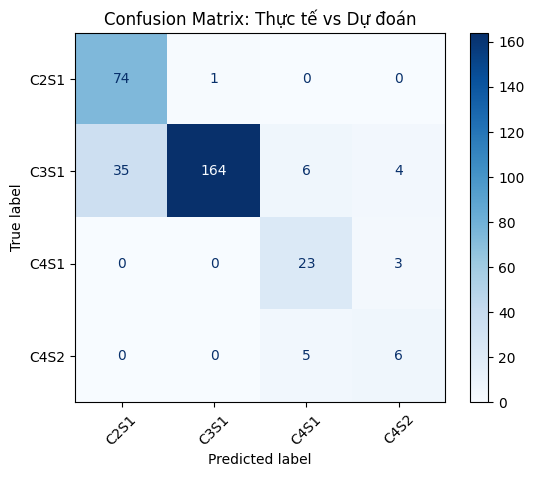

Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------------------------------
Kết quả khi tối ưu các tham số của mô hình
Best params: {'svc__C': 1000, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best CV f1_macro: 0.7646607719620494
              precision    recall  f1-score   support

        C2S1     0.8506    0.9867    0.9136        75
        C3S1     0.9796    0.9187    0.9481       209
        C4S1     0.7600    0.7308    0.7451        26
        C4S2     0.3846    0.4545    0.4167        11

    accuracy                         0.9034       321
   macro avg     0.7437    0.7727    0.7559       321
weighted avg     0.9113    0.9034    0.9054       321



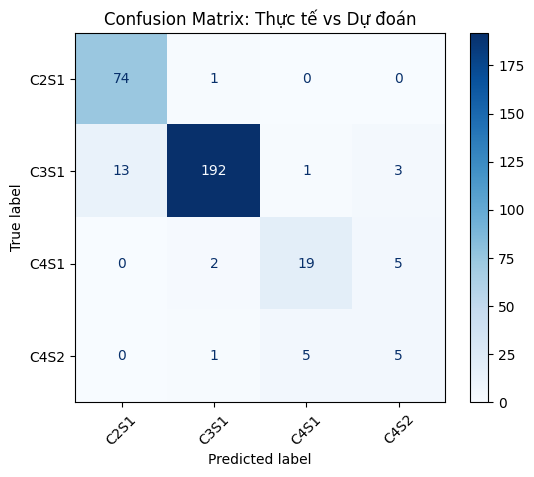

In [14]:
test_svm(df_4_class_pca, 0.3)

### kịch bản 3 (Train/Test = 0.6/0.4)

Kết quả của mô hình khi chưa được tối ưu các tham số
              precision    recall  f1-score   support

        C2S1       0.69      0.99      0.81        99
        C3S1       1.00      0.77      0.87       279
        C4S1       0.58      0.89      0.70        35
        C4S2       0.33      0.36      0.34        14

    accuracy                           0.82       427
   macro avg       0.65      0.75      0.68       427
weighted avg       0.87      0.82      0.82       427



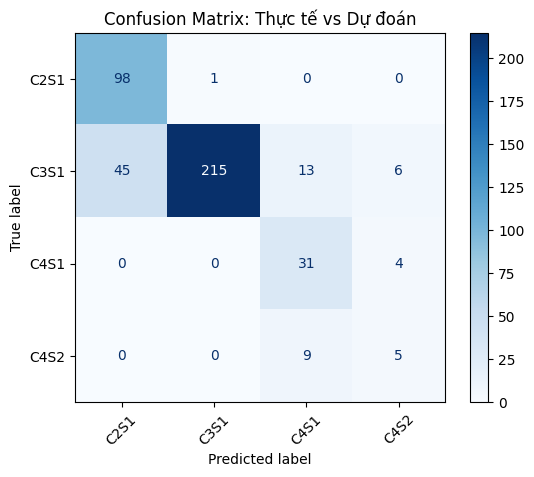

Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------------------------------
Kết quả khi tối ưu các tham số của mô hình
Best params: {'svc__C': 100, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best CV f1_macro: 0.7394025850433993
              precision    recall  f1-score   support

        C2S1     0.8839    1.0000    0.9384        99
        C3S1     1.0000    0.9319    0.9647       279
        C4S1     0.7895    0.8571    0.8219        35
        C4S2     0.5294    0.6429    0.5806        14

    accuracy                         0.9321       427
   macro avg     0.8007    0.8580    0.8264       427
weighted avg     0.9404    0.9321    0.9343       427



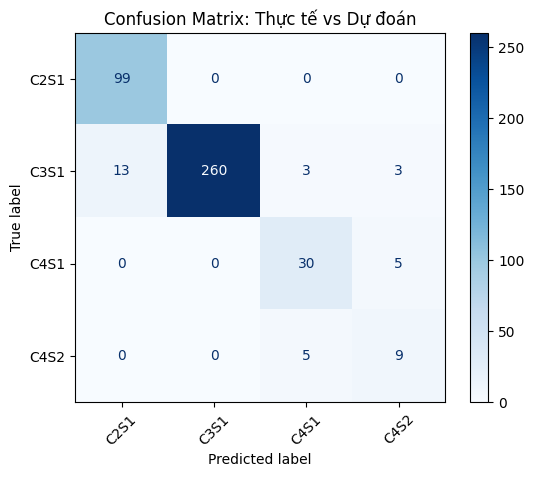

In [15]:
test_svm(df_4_class_pca, 0.4)

Nhận xét :
- mô hình cũng đạt kết quả tương tự khi chưa giảm chiều dữ liệu

## Thực hiện giảm chiều dữ liệu bằng lda, đầu ra là 9 class

Kết quả của mô hình khi chưa được tối ưu các tham số
              precision    recall  f1-score   support

        C2S1       0.78      1.00      0.88        50
        C3S1       0.98      0.82      0.89       140
        C3S2       0.00      0.00      0.00         2
        C3S3       1.00      1.00      1.00         1
        C4S1       0.75      0.83      0.79        18
        C4S2       0.36      0.57      0.44         7
        C4S3       0.00      0.00      0.00         1
        C4S4       0.50      1.00      0.67         1
          OG       1.00      1.00      1.00         1

    accuracy                           0.85       221
   macro avg       0.60      0.69      0.63       221
weighted avg       0.88      0.85      0.86       221



f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

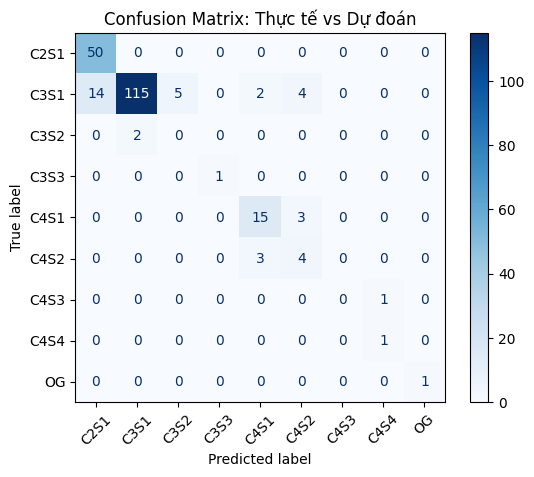

Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------------------------------
Kết quả khi tối ưu các tham số của mô hình
Best params: {'svc__C': 1000, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best CV f1_macro: 0.7094518648171354
              precision    recall  f1-score   support

        C2S1     0.8929    1.0000    0.9434        50
        C3S1     0.9767    0.9000    0.9368       140
        C3S2     0.0000    0.0000    0.0000         2
        C3S3     0.0000    0.0000    0.0000         1
        C4S1     0.8333    0.8333    0.8333        18
        C4S2     0.3636    0.5714    0.4444         7
        C4S3     0.0000    0.0000    0.0000         1
        C4S4     0.5000    1.0000    0.6667         1
          OG     1.0000    1.0000    1.0000         1

    accuracy                         0.8914       221
   macro avg     0.5074    0.5894    0.5361       221
weighted avg     0.9069    0.8914    0.8964       221



f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

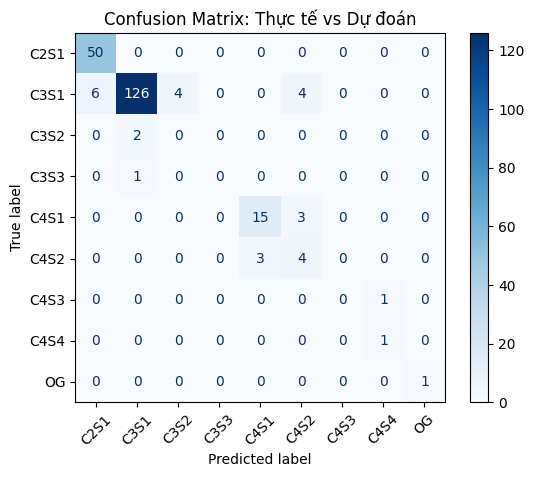

In [16]:
test_svm(df_9_class_lda, test_size=0.2)

Kết quả của mô hình khi chưa được tối ưu các tham số
              precision    recall  f1-score   support

        C2S1       0.77      1.00      0.87        75
        C3S1       0.98      0.83      0.90       209
        C3S2       0.14      0.25      0.18         4
        C3S3       0.67      1.00      0.80         2
        C4S1       0.77      0.88      0.82        26
        C4S2       0.54      0.64      0.58        11
        C4S3       0.00      0.00      0.00         1
        C4S4       0.67      1.00      0.80         2
          OG       1.00      1.00      1.00         1

    accuracy                           0.86       331
   macro avg       0.62      0.73      0.66       331
weighted avg       0.89      0.86      0.87       331



f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

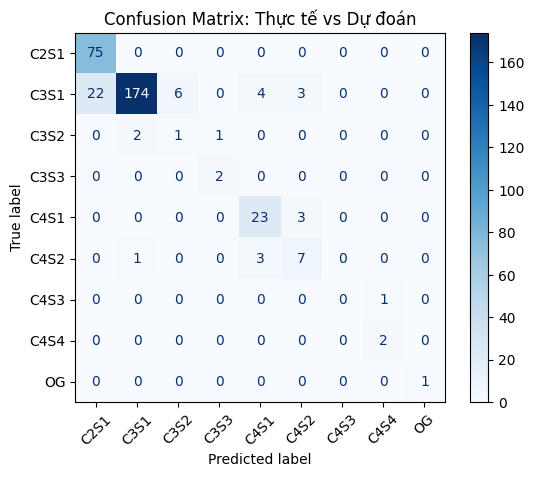

Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------------------------------
Kết quả khi tối ưu các tham số của mô hình
Best params: {'svc__C': 1000, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best CV f1_macro: 0.6438846627796574
              precision    recall  f1-score   support

        C2S1     0.8333    1.0000    0.9091        75
        C3S1     0.9787    0.8804    0.9270       209
        C3S2     0.1667    0.2500    0.2000         4
        C3S3     0.5000    0.5000    0.5000         2
        C4S1     0.8077    0.8077    0.8077        26
        C4S2     0.4667    0.6364    0.5385        11
        C4S3     0.0000    0.0000    0.0000         1
        C4S4     0.6667    1.0000    0.8000         2
          OG     1.0000    1.0000    1.0000         1

    accuracy                         0.8822       331
   macro avg     0.6022    0.6749    0.6314       331
weighted avg     0.8978    0.8822    0.8859       331



f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

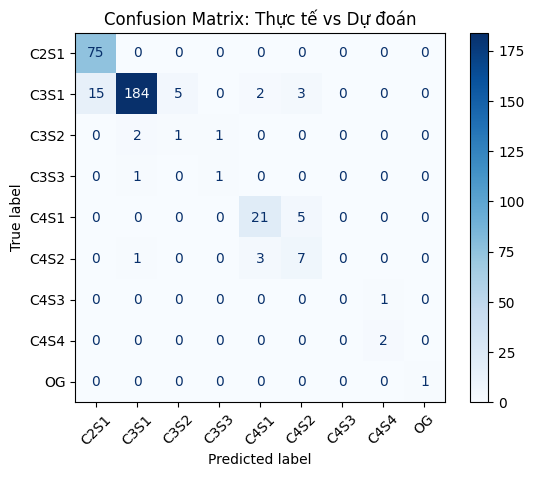

In [17]:
test_svm(df_9_class_lda, test_size=0.3)

Kết quả của mô hình khi chưa được tối ưu các tham số
              precision    recall  f1-score   support

        C2S1       0.74      1.00      0.85        99
        C3S1       0.99      0.80      0.89       279
        C3S2       0.22      0.40      0.29         5
        C3S3       0.40      1.00      0.57         2
        C4S1       0.72      0.83      0.77        35
        C4S2       0.39      0.50      0.44        14
        C4S3       0.33      0.50      0.40         2
        C4S4       0.67      0.67      0.67         3
          OG       1.00      1.00      1.00         2

    accuracy                           0.83       441
   macro avg       0.61      0.74      0.65       441
weighted avg       0.87      0.83      0.84       441



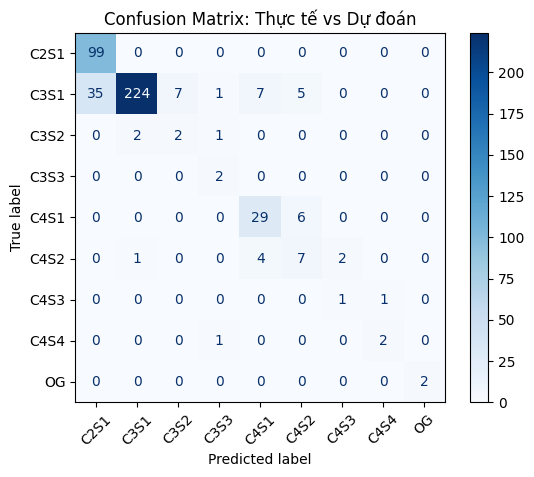

Fitting 3 folds for each of 100 candidates, totalling 300 fits


f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\model_selection\_split.py:813: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


----------------------------------
Kết quả khi tối ưu các tham số của mô hình
Best params: {'svc__C': 10, 'svc__gamma': 1, 'svc__kernel': 'rbf'}
Best CV f1_macro: 0.5573753123188004
              precision    recall  f1-score   support

        C2S1     0.8534    1.0000    0.9209        99
        C3S1     0.9879    0.8781    0.9298       279
        C3S2     0.3333    0.4000    0.3636         5
        C3S3     0.5000    0.5000    0.5000         2
        C4S1     0.6522    0.8571    0.7407        35
        C4S2     0.3684    0.5000    0.4242        14
        C4S3     0.0000    0.0000    0.0000         2
        C4S4     0.5000    0.3333    0.4000         3
          OG     1.0000    1.0000    1.0000         2

    accuracy                         0.8776       441
   macro avg     0.5773    0.6076    0.5866       441
weighted avg     0.8940    0.8776    0.8809       441



f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
f:\Project\Ground_Water_Classifier\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

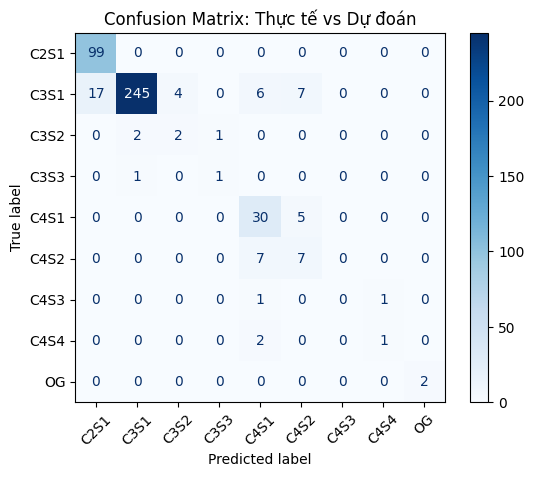

In [18]:
test_svm(df_9_class_lda, test_size=0.4)

## Thực hiện giảm chiều dữ liệu bằng lda, đầu ra là 4 class

### Kịch bản 1 (Train/Test = 0.8/0.2)

Kết quả của mô hình khi chưa được tối ưu các tham số
              precision    recall  f1-score   support

        C2S1       0.77      0.98      0.86        50
        C3S1       0.99      0.87      0.93       140
        C4S1       0.67      0.71      0.69        17
        C4S2       0.44      0.57      0.50         7

    accuracy                           0.87       214
   macro avg       0.72      0.78      0.74       214
weighted avg       0.90      0.87      0.88       214



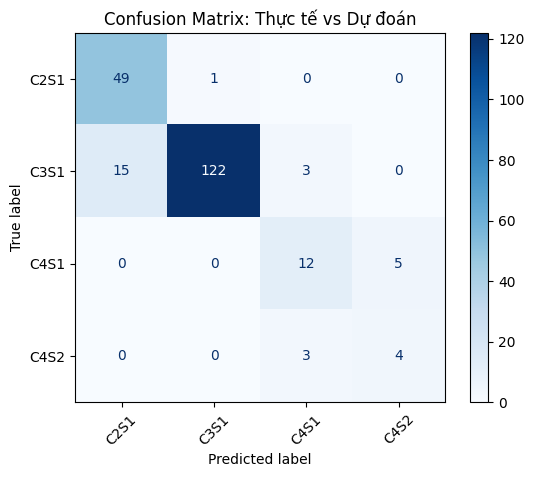

Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------------------------------
Kết quả khi tối ưu các tham số của mô hình
Best params: {'svc__C': 100, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best CV f1_macro: 0.804982352664842
              precision    recall  f1-score   support

        C2S1     0.8033    0.9800    0.8829        50
        C3S1     0.9919    0.8786    0.9318       140
        C4S1     0.5909    0.7647    0.6667        17
        C4S2     0.4286    0.4286    0.4286         7

    accuracy                         0.8785       214
   macro avg     0.7037    0.7630    0.7275       214
weighted avg     0.8976    0.8785    0.8829       214



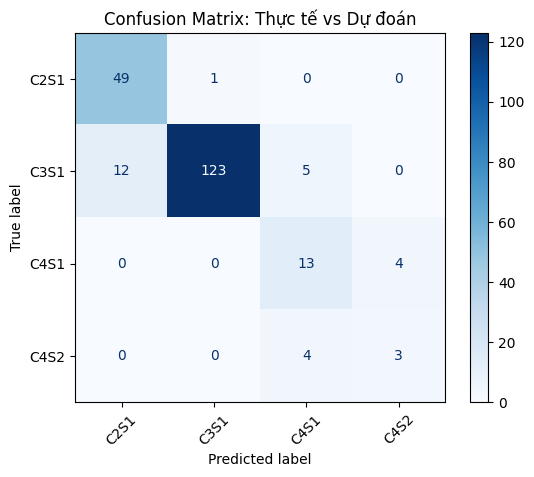

In [19]:
test_svm(df_4_class_lda, test_size=0.2)

### Kịch bản 2 (Train/Test = 0.7/0.3)

Kết quả của mô hình khi chưa được tối ưu các tham số
              precision    recall  f1-score   support

        C2S1       0.76      1.00      0.86        75
        C3S1       1.00      0.87      0.93       209
        C4S1       0.75      0.81      0.78        26
        C4S2       0.54      0.64      0.58        11

    accuracy                           0.88       321
   macro avg       0.76      0.83      0.79       321
weighted avg       0.91      0.88      0.89       321



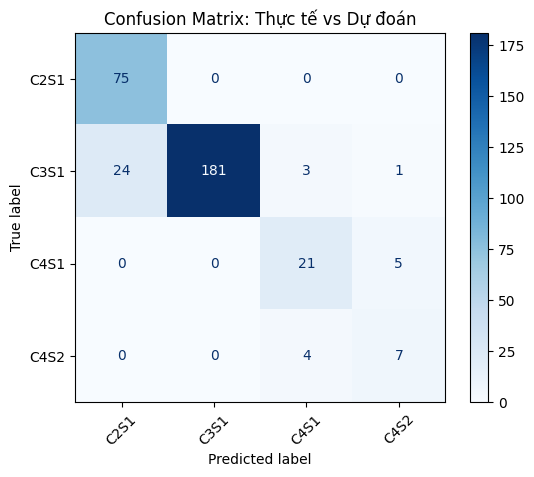

Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------------------------------
Kết quả khi tối ưu các tham số của mô hình
Best params: {'svc__C': 0.1, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}
Best CV f1_macro: 0.7697464652941463
              precision    recall  f1-score   support

        C2S1     0.9844    0.8400    0.9065        75
        C3S1     0.9398    0.9713    0.9553       209
        C4S1     0.7419    0.8846    0.8070        26
        C4S2     0.6000    0.5455    0.5714        11

    accuracy                         0.9190       321
   macro avg     0.8165    0.8103    0.8101       321
weighted avg     0.9226    0.9190    0.9187       321



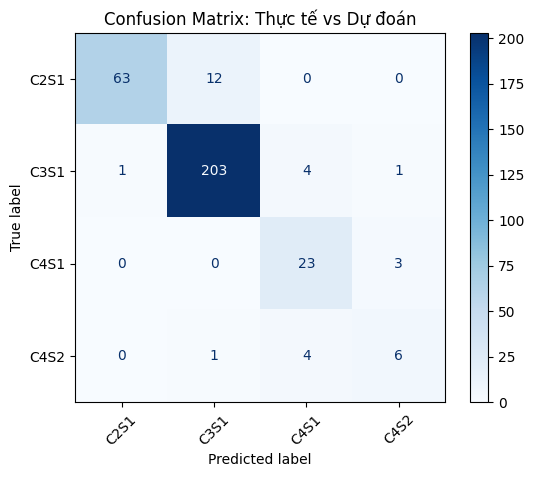

In [20]:
test_svm(df_4_class_lda, test_size=0.3)

### Kịch bản 3 (Train/Test = 0.6/0.4)

Kết quả của mô hình khi chưa được tối ưu các tham số
              precision    recall  f1-score   support

        C2S1       0.74      1.00      0.85        99
        C3S1       1.00      0.83      0.91       279
        C4S1       0.72      0.83      0.77        35
        C4S2       0.45      0.71      0.56        14

    accuracy                           0.87       427
   macro avg       0.73      0.84      0.77       427
weighted avg       0.90      0.87      0.87       427



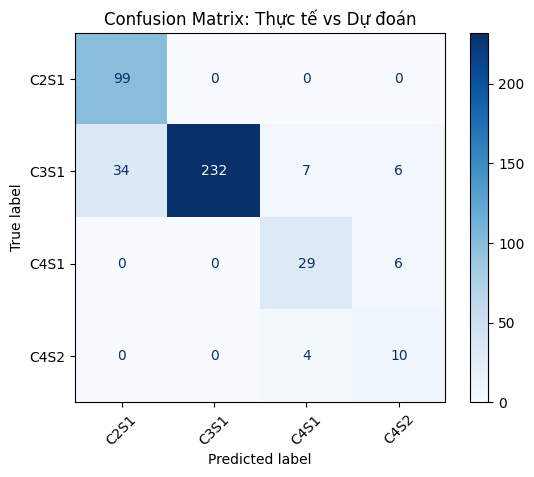

Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------------------------------
Kết quả khi tối ưu các tham số của mô hình
Best params: {'svc__C': 1000, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}
Best CV f1_macro: 0.7823552735789706
              precision    recall  f1-score   support

        C2S1     0.8448    0.9899    0.9116        99
        C3S1     0.9922    0.9068    0.9476       279
        C4S1     0.7143    0.8571    0.7792        35
        C4S2     0.5714    0.5714    0.5714        14

    accuracy                         0.9110       427
   macro avg     0.7807    0.8313    0.8025       427
weighted avg     0.9214    0.9110    0.9131       427



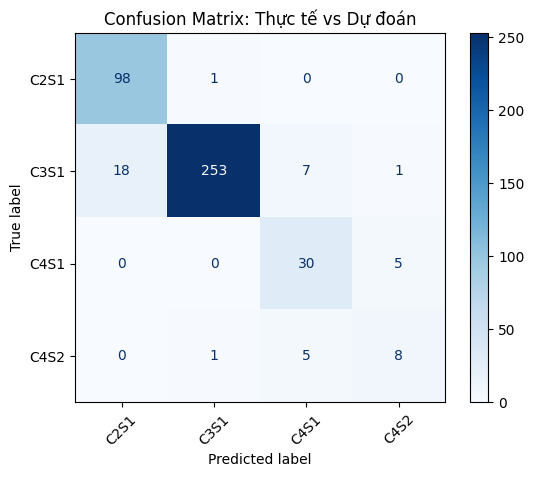

In [21]:
test_svm(df_4_class_lda, test_size=0.4)

Nhận xét chung :
- kết quả của mô hình tốt khi dữ liệu chỉ còn 4 class
- kernel tối ưu cho bài toán này là linear và rbf


## Upsampling các class thiểu số

In [22]:
TARGETS_4 = {"C2S1": 280, "C4S1": 240, "C4S2": 200}

def test_svm_with_smote(df, test_size, targets_dict=TARGETS_4):
    target = "Classification"

    #Split dữ liệu
    x = df.drop(target, axis=1).to_numpy()
    y_str = df[target].to_numpy()

    LB = LabelEncoder()
    y = LB.fit_transform(y_str)  # 0..C-1

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=test_size, random_state=42, stratify=y
    )


    targets_encoded = {}
    for name, tgt in targets_dict.items():
        if name in LB.classes_:
            cid = int(LB.transform([name])[0])
            targets_encoded[cid] = tgt

    cnt_before = Counter(y_train)
    sampling_strategy = {
        cid: tgt for cid, tgt in targets_encoded.items()
        if cid in cnt_before and tgt > cnt_before[cid]
    }

    smote = SMOTE(
        sampling_strategy=sampling_strategy,
        random_state=42,
        k_neighbors=5
    )

    model = ImbPipeline(steps=[
        ("smote", smote),
        ("scaler", StandardScaler()),
        ("svc", SVC(kernel="rbf", C=1, gamma="scale", class_weight="balanced", random_state=42))
    ])

    # Fit baseline
    model.fit(x_train, y_train)

    #Evaluate baseline
    y_pred = model.predict(x_test)
    classes = model.named_steps["svc"].classes_  # = np.unique(y) theo fit

    print("Kết quả của mô hình khi chưa tối ưu tham số")
    print(classification_report(
        y_test, y_pred,
        labels=classes,
        target_names=LB.inverse_transform(classes),
        zero_division=0
    ))

    cm = confusion_matrix(y_test, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LB.inverse_transform(classes))
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix: Thực tế vs Dự đoán")
    plt.tight_layout()
    plt.show()

    # GridSearchCV
    param_grid = {
        "svc__C": [0.1, 1, 10, 100, 1000],
        "svc__gamma": ["scale", 1e-3, 1e-2, 1e-1, 1],
        "svc__kernel": ["linear", "poly", "rbf", "sigmoid"],
    }

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring="f1_macro",
        cv=cv,
        n_jobs=-1,
        verbose=2,
        refit=True
    )
    gs.fit(x_train, y_train)

    print("----------------------------------")
    print("Kết quả khi tối ưu tham số")
    print("Best params:", gs.best_params_)
    print("Best CV f1_macro:", gs.best_score_)

    # Evaluate best model
    best_model = gs.best_estimator_
    y_pred_best = best_model.predict(x_test)

    classes_best = best_model.named_steps["svc"].classes_
    print(classification_report(
        y_test, y_pred_best,
        labels=classes_best,
        target_names=LB.inverse_transform(classes_best),
        digits=4,
        zero_division=0
    ))

    cm = confusion_matrix(y_test, y_pred_best, labels=classes_best)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LB.inverse_transform(classes_best))
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix: Thực tế vs Dự đoán")
    plt.tight_layout()
    plt.show()


Kết quả của mô hình khi chưa tối ưu tham số
              precision    recall  f1-score   support

        C2S1       0.72      1.00      0.84        50
        C3S1       1.00      0.84      0.91       140
        C4S1       0.74      0.82      0.78        17
        C4S2       0.50      0.57      0.53         7

    accuracy                           0.87       214
   macro avg       0.74      0.81      0.77       214
weighted avg       0.90      0.87      0.87       214



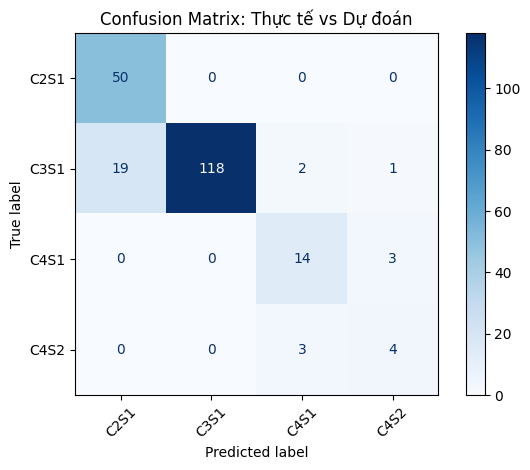

Fitting 3 folds for each of 100 candidates, totalling 300 fits
----------------------------------
Kết quả khi tối ưu tham số
Best params: {'svc__C': 1000, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Best CV f1_macro: 0.7953061379841467
              precision    recall  f1-score   support

        C2S1     1.0000    1.0000    1.0000        50
        C3S1     1.0000    0.9929    0.9964       140
        C4S1     0.8000    0.7059    0.7500        17
        C4S2     0.4000    0.5714    0.4706         7

    accuracy                         0.9579       214
   macro avg     0.8000    0.8175    0.8043       214
weighted avg     0.9645    0.9579    0.9605       214



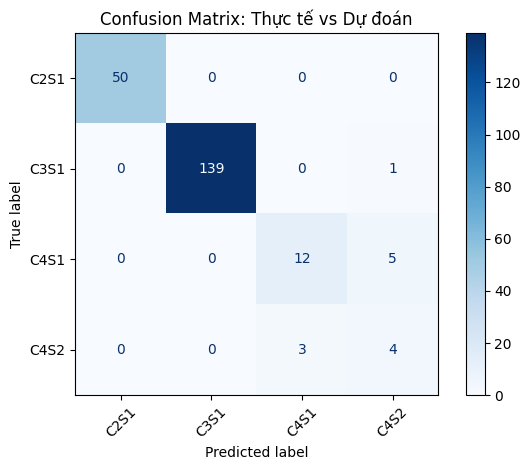

In [23]:
test_svm_with_smote(df_4_class, 0.2)